<a href="https://colab.research.google.com/github/iffigueroa/text-marketing-analytics/blob/main/dtsa_5799_unsupervised_text_classification_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Text Classification for Marketing Analytics


This project aims to perform unsupervised deep learning, on extensive e-commerce review data from Amazon. The focus is on developing topic models derived from Nike product reviews, with the goal of extracting useful insights about consumer preferences and sentiments. By utilizing both topic modeling and sentiment analysis methods, we seek to uncover what attributes people appreciate and dislike about the reviewed Nike products, specifically thier shoes.

The approach involves leveraging unsupervised deep learning techniques to derive meaningful topics from the reviews. By understanding primary topics within reviews, we can identify key attributes that stand out to consumers, and by analyzing sentiment within the reviews, can pinpoint specific aspects that drive positive or negative perceptions of Nike shoes.

Ultimately, the goal is to provide actionable insights that could enhance understanding of consumer preferences, leading to more effective marketing strategies and the development of shoes that best meet consumer needs.


# Project Setup

## Imports & Installs

In [1]:
import importlib.util

if importlib.util.find_spec('numba'):
    !pip uninstall -y numba
if importlib.util.find_spec('tensorflow'):
    !pip uninstall -y tensorflow
if not importlib.util.find_spec('lda'):
    !pip install lda
if not importlib.util.find_spec('tmtoolkit'):
    !pip install "tmtoolkit[recommended]"

In [2]:
from textblob import TextBlob
from tmtoolkit.corpus import (
  Corpus,tokens_table, print_summary, lemmatize, to_lowercase, filter_for_pos, remove_chars, filter_clean_tokens,remove_common_tokens, remove_uncommon_tokens,corpus_num_tokens, corpus_tokens_flattened,dtm, vocabulary
)
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, ldamodel_top_doc_topics
from tmtoolkit.topicmod.tm_lda import compute_models_parallel
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.visualize import parameters_for_ldavis
import numpy as np
from string import punctuation
import json
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import re


## Extracting the Data

Before we can work on topic modeling, I'll start by loading and extracting the relevant data from the dataset. For this project I was provided with two json files with review product reviews and their metadata, that I have stored in a Google drive. In the section below I load both json files, and only reviews and metadata associated with Nike product reviews.

I start by loading the metadata, and capturing ASIN ids related to Nike Shoes products, then I load and extract reviews related to those products.

In [3]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/2_topic_modeling"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if 'nike_asins' not in locals():
  nike_asins = {}
  print("Finding Nike ASINs...")
  with open(f"{path}/meta_Clothing_Shoes_and_Jewelry.jsonl") as products:
      for product in products:
          data = json.loads(product)
          categories = [c.lower() for c in
                        list(itertools.chain(*data.get("categories", [])))]
          if "nike" in categories:
            if (data.get("salesRank") and "Shoes" in data['salesRank'].keys()):
              asin = data['asin']
              product = data['title']
              nike_asins[asin] = product


Finding Nike ASINs...


In [5]:
print(f"There are {(len(nike_asins))} ids within this dataset.")

There are 6599 ids within this dataset.


In [6]:
if 'nike_reviews' not in locals():
  print("Finding Nike Shoe Reviews...")
  all_asins = nike_asins.keys()
  review_text = []
  ratings = []
  product = []
  with open(f"{path}/reviews_Clothing_Shoes_and_Jewelry_5.json") as reviews:
      for review in reviews:
          data = json.loads(review)
          if data["asin"] in all_asins:
            review_text.append(data['summary'] +" "+data["reviewText"])
            ratings.append(data['overall'])
            product.append(nike_asins[data["asin"]])
  nike_reviews = pd.DataFrame({
      "review": review_text,
      'rating': ratings,
      'product': product
  })


Finding Nike Shoe Reviews...


In [7]:
print(f"Found {len(nike_reviews)} Nike reviews.\n")
print("Some example reviews:")
nike_reviews.head()

Found 303 Nike reviews.

Some example reviews:


,review,rating,product
0,"Quality Shoe I wear a size 10.5&#34; shoe, ord...",5.0,Nike Men's Downshifter 5 Running Shoes
1,"super light, great running shoe fits perfectly...",5.0,Nike Men's Downshifter 5 Running Shoes
2,Great running shoe This shoe is very light and...,5.0,Nike Men's Downshifter 5 Running Shoes
3,Very good shoes As always this shoes were what...,4.0,Nike Men's Downshifter 5 Running Shoes
4,"Great! These shoes were shipped quickly, came ...",5.0,Nike Men's Downshifter 5 Running Shoes


In [8]:
reviewed_products = nike_reviews['product'].unique()
print(reviewed_products)

["Nike Men's Downshifter 5 Running Shoes"
 "Nike Men's Benassi Swoosh Slide Sandal"
 "Nike The Overplay VII Men's Basketball Shoe"
 'Nike Womens Celso Girl Thong' "Nike Men's Comfort Slide 2 Sandal"
 "Nike Men's NIKE SWEET CLASSIC LEATHER CASUAL SHOES"
 'Nike Mens Cortez Basic Leather 06 Fashion Casual Sneaker'
 "Nike Men's Benassi JDI Slide Sandal" 'Nike Air Visi Pro Iii Nbk'
 "Nike Men's Flex Run 2013 Running Shoe"
 "Nike Benassi JDI Slide Women's Sandals" "Nike Women's Comfort Slide"
 "Nike Women's Comfort Thong Sandal"
 'Nike Flex Experience Rn2 Running Shoe Womens'
 'Nike Womens Free 5.0 TR Fit 4 Cross Training Shoes'
 'Nike Free 5.0 Womens Running Shoes'
 "Nike Women's Revolution 2 Running Shoe"
 "Nike Men's Benassi Solarsoft Slide Sandal"
 "Nike Air Monarch IV Men's Cross Training Shoes"
 "NIKE Dart 9 Men's Running Shoes" "Nike Women's Dart 9 Running Shoe"
 'Nike Lady Air Max+ 2012 Running Shoes'
 "Nike Men's Relentless 2 Running Shoe"
 'Nike Zoom Vomero+ 7 Womens Size 6 Gray Me


## Topic Modeling
In the previous section, just over 300 Review for Nike shoes were extracted. In addition to the reviews, the ratings and product names for each were also stored. Later on we can use ratings and/or sentiment to help figure out which topics are relevant to positive and negative reviews and the product name to associate sentiment with product as well.

### Corpus Building & Preprocessing

Next, from the reviews a corpus will be constructed, and the text will be preprocessed prior to performing the topic modeling. The following are the tasks performed for preprocessing:
- Lemmatization
- Text case normalization
- Removal of punctuation
- Removal of stop words
- Removal of numbers
- Removal of words shorter than 3 characters
- Removal of tokens found in more than 95% of documents
- Removal of tokens found in fewer than .01% of documents
- Filter out pars of speech that are not Nouns or Adjectives


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stopwordsset = set(stopwords.words("english"))
stopwordsset.add('nike')
stopwordsset.add('get')
stopwordsset.add('shoe')
stopwordsset.add('try')
stopwordsset.add('use')
stopwordsset.add('say')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
def build_corpus(texts, lang="en"):
  """
  Build and preprocess a corpus, include:
  - lemmatization, text case normalization, punctuation/number/empty string removal
  - removal of common/uncommon across document tokens
  Returns processed corpus and addociated text.
  """
  corpus = Corpus({ i:r for i, r in enumerate(texts) }, language=lang)
  lemmatize(corpus, inplace=True)
  to_lowercase(corpus, inplace=True)
  remove_chars(corpus, chars=punctuation, inplace=True)
  filter_clean_tokens(corpus, remove_shorter_than=3, remove_empty=True, remove_numbers=True, remove_stopwords=stopwordsset, inplace=True)
  filter_for_pos(corpus, search_pos=['N', 'ADJ'], inplace = True)
  remove_common_tokens(corpus, df_threshold=0.95)
  remove_uncommon_tokens(corpus, df_threshold=0.001)

  processed_texts = [corpus[i] for i in range(len(texts))]
  return corpus, processed_texts

reviews_corpus, processed_texts = build_corpus(nike_reviews['review'])

In [11]:
print_summary(reviews_corpus)


Corpus with 303 documents in English
> 0 (26 tokens): quality size insole bit different company arch sup...
> 1 (28 tokens): super light great high arch narrow foot material g...
> 2 (4 tokens): great light comfortable size
> 3 (6 tokens): good confortable good quality thing ligth
> 4 (6 tokens): great box cool swoosh dark happy
> 5 (41 tokens): happy quick shipping idea type athletic size probl...
> 6 (9 tokens): nice wide toe box son wide foot wide pair
> 7 (11 tokens): excellent nice price excellent show question nice ...
> 8 (10 tokens): nice sneaker sneaker lightweight fit flaw complain...
> 9 (14 tokens): run small runs small whole size big order small ba...
(and 293 more documents)
total number of tokens: 4156 / vocabulary size: 1051


In [12]:
tokens_table(reviews_corpus)


,doc,position,token,is_punct,is_stop,lemma,like_num,pos,tag
0,0,0,quality,False,False,Quality,False,PROPN,NNP
1,0,1,size,False,False,size,False,NOUN,NN
2,0,2,insole,False,False,insole,False,NOUN,NNS
3,0,3,bit,False,False,bit,False,NOUN,NN
4,0,4,different,False,False,different,False,ADJ,JJ
...,...,...,...,...,...,...,...,...,...
4151,302,13,durable,False,False,durable,False,ADJ,JJ
4152,302,14,quality,False,False,quality,False,NOUN,NN
4153,302,15,stylish,False,False,stylish,False,ADJ,JJ
4154,302,16,good,False,False,good,False,ADJ,JJ


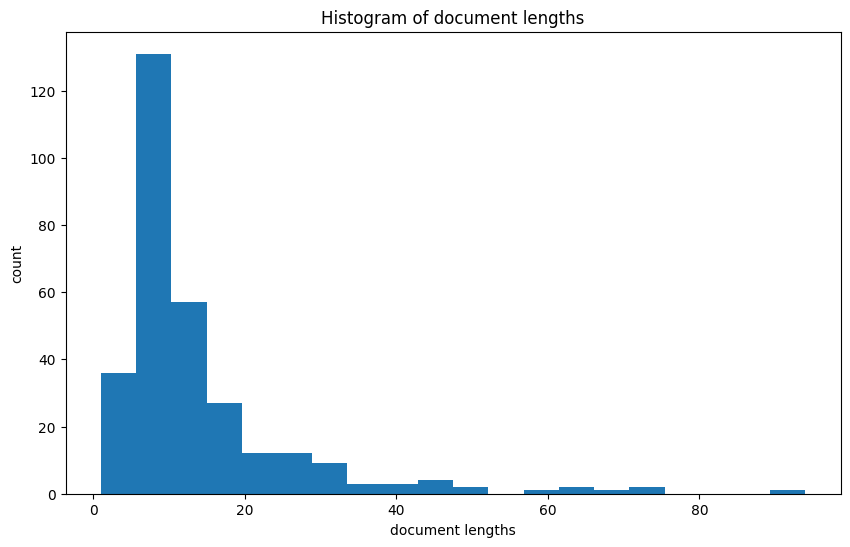

In [13]:
from tmtoolkit.corpus.visualize import (plot_doc_lengths_hist, plot_doc_frequencies_hist, plot_ranked_vocab_counts)
fig, ax = plt.subplots(figsize=(10, 6))   # make the plot larger
plot_doc_lengths_hist(fig, ax, reviews_corpus, y_log=False, bins=20)  # use 20 bins
plt.show();

Above we see that most reviews have fewer than 20 words, though some are longer.

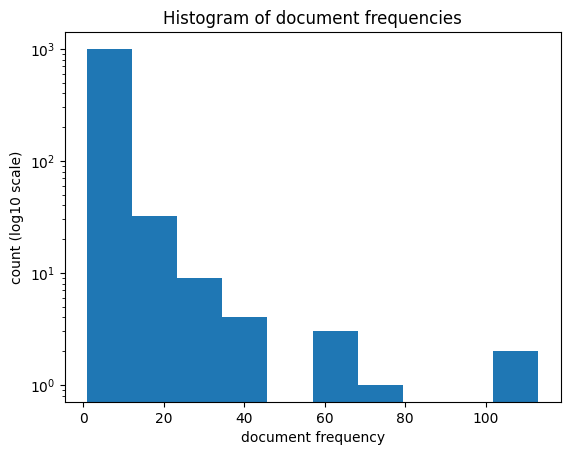

In [14]:
fig, ax = plt.subplots()
plot_doc_frequencies_hist(fig, ax, reviews_corpus)
plt.show();

Here, we can see a plot that displays with what frequency most words are repeated across documents. In our case it appears that most of the words in the vocabulary being used don't appear across all documents, or even most documents. They may appear in a few but that's it. This means we have a low document frequency, indicating that this dataset is a good candidate for defining distinct topics.

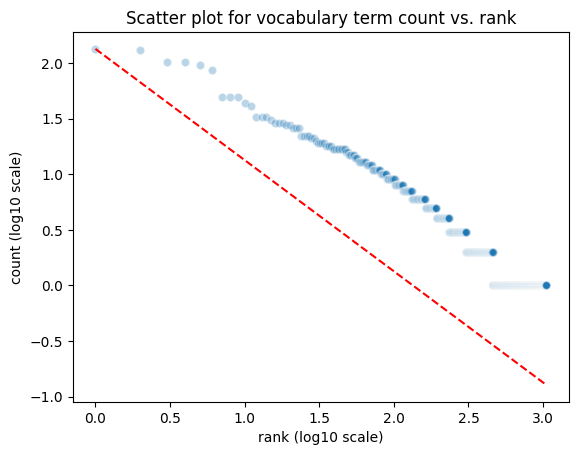

In [15]:
fig, ax = plt.subplots()
plot_ranked_vocab_counts(fig, ax, reviews_corpus, zipf=True)
plt.show();

In this last exploratory plot, we see how each of the terms in our vocabulary (of just over 1000 words) is distributed across documents. Some are used quite frequently, but most are not.

In [16]:
vocab = vocabulary(reviews_corpus)
dtm = dtm(reviews_corpus)
doc_labels = reviews_corpus.doc_labels

In [17]:
len(vocab)

1051

In [18]:
dtm.shape

(303, 1051)

In [19]:

len(doc_labels)

303

In [20]:
dtms = {
    "reviews_corpus": dtm
}


### Evaluating Topic Model Hyperparameters
Before we make the final topic model, this section will explore which values for number of topics, alpha, and beta may be optimal for this analysis. The next few sections of code will explore:

- Ideal number of topics
- High and low $\alpha$  values
- High and low $\beta$/$\eta$ values

Note that $\alpha$ is the parameter that controls sparsity of document-topic distributions. If $\alpha$  is high, we expect documents to contain many topics, if it is low, we expect it to contain fewer topics.

For $\beta$, this parameter describes the sparsity of topic-word distributions. So if we have a high $\beta$ we'd expect the topic to relate a lot of words, whereas a smaller value we'd expect to use fewer words.

#### Number of Topics & Alpha

In [21]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results

def evaluate_model(dtms, param_name, constant_params, varying_params = None):
  print(f"{len(varying_params)} parameter sets to test.")
  models = compute_models_parallel(dtms, constant_parameters=constant_params, varying_parameters=varying_params)
  eval_results = evaluate_topic_models(
    dtms['reviews_corpus'],
    varying_parameters=varying_params,
    constant_parameters=constant_params,
  )
  print(eval_results[0:5])

  # Plot the evaluation results
  results_by_n_topics = results_by_parameter(eval_results, param_name)
  plot_eval_results(results_by_n_topics)


In [22]:
# Here we can do some hyperparameter tuning/evaluation
lda_constant_params = {
    'n_iter': 100,
    'random_state': 555,
}

10 parameter sets to test.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[({'n_topics': 1, 'alpha': 1.0, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': nan, 'coherence_mimno_2011': -392.29914669049253}), ({'n_topics': 6, 'alpha': 0.16666666666666666, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.23256745149104172, 'coherence_mimno_2011': -394.6823042932571}), ({'n_topics': 11, 'alpha': 0.09090909090909091, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.17473952720344696, 'coherence_mimno_2011': -373.1316652855476}), ({'n_topics': 16, 'alpha': 0.0625, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.16884558505513586, 'coherence_mimno_2011': -345.91499190676404}), ({'n_topics': 21, 'alpha': 0.047619047619047616, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.15728893494581458, 'coherence_mimno_2011': -322.9112830917594})]


/usr/local/lib/python3.10/dist-packages/tmtoolkit/topicmod/visualize.py:833: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(**subplots_adjust_kwargs)


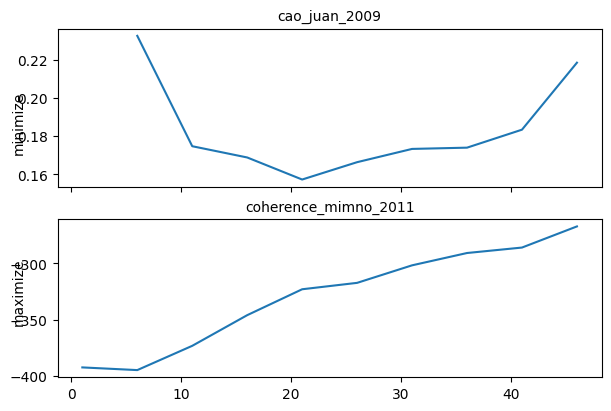

In [23]:
lda_varying_params_low_alpha = [
  {
    'n_topics': k,
    'alpha': 1/k,
    'eta': 0.1
  } for k in range(1, 50, 5)
]


evaluate_model(dtms, 'n_topics', lda_constant_params, lda_varying_params_low_alpha)

10 parameter sets to test.


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[({'n_topics': 1, 'alpha': 0.1, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': nan, 'coherence_mimno_2011': -392.29914669049253}), ({'n_topics': 6, 'alpha': 0.016666666666666666, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.4219384316366025, 'coherence_mimno_2011': -387.12482157147906}), ({'n_topics': 11, 'alpha': 0.00909090909090909, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.33348948815708745, 'coherence_mimno_2011': -369.98178053129783}), ({'n_topics': 16, 'alpha': 0.00625, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.3073550554519438, 'coherence_mimno_2011': -379.132197593349}), ({'n_topics': 21, 'alpha': 0.004761904761904762, 'eta': 0.1, 'n_iter': 100, 'random_state': 555}, {'cao_juan_2009': 0.2532397507944856, 'coherence_mimno_2011': -339.24962399386163})]


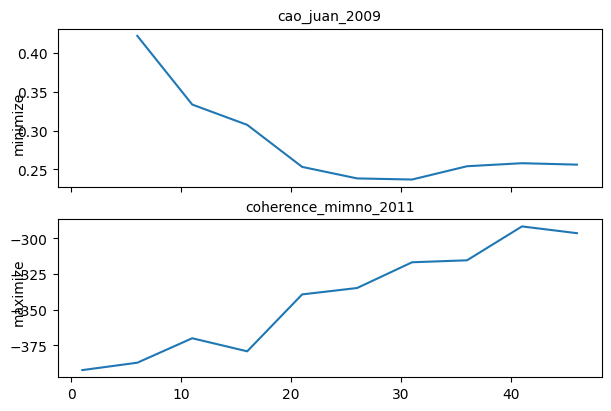

In [24]:
lda_varying_params_high_alpha = [
  {
    'n_topics': k,
    'alpha': 1/(10*k),
    'eta': 0.1
  } for k in range(1, 50, 5)
]

evaluate_model(dtms, 'n_topics', lda_constant_params, lda_varying_params_high_alpha)

From the above, wether we want to use a high or low alpha, it seems that the optimal value of k will be around 20-30, so I'll proceed with 25. In the next section we'll evaluate beta and try using both high and low alphas defined by $1/k$ and $1/(10*k)$

#### Beta

In [25]:
k = 25 # chosen in above analysis

lda_constant_params['n_topics'] = k
lda_constant_params['alpha'] = 1/k

lda_varying_params_eta = [
  {
    'eta': x/100,
  } for x in range(1, 50, 1)
]

49 parameter sets to test.
[({'eta': 0.01, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.07558218673837226, 'coherence_mimno_2011': -341.26968602830993}), ({'eta': 0.02, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.08620213065292973, 'coherence_mimno_2011': -340.5743094843632}), ({'eta': 0.04, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.10922591465309367, 'coherence_mimno_2011': -346.7751278461941}), ({'eta': 0.03, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.09612751944040035, 'coherence_mimno_2011': -340.0380662871563}), ({'eta': 0.05, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.04}, {'cao_juan_2009': 0.11227370822155215, 'coherence_mimno_2011': -335.84844804727})]


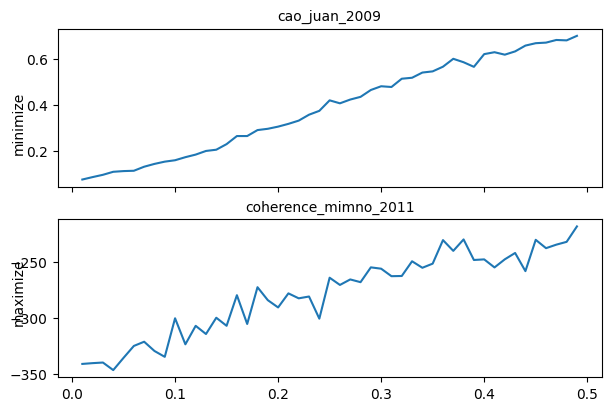

In [26]:
evaluate_model(dtms, 'eta', lda_constant_params, lda_varying_params_eta)

49 parameter sets to test.
[({'eta': 0.02, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.1647675744067143, 'coherence_mimno_2011': -363.41178571725146}), ({'eta': 0.01, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.13311127809319584, 'coherence_mimno_2011': -360.9561654374938}), ({'eta': 0.04, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.18628571177099185, 'coherence_mimno_2011': -350.81872399708436}), ({'eta': 0.03, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.16954882364600762, 'coherence_mimno_2011': -347.52935797233613}), ({'eta': 0.05, 'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004}, {'cao_juan_2009': 0.2060802602778449, 'coherence_mimno_2011': -353.00187735103674})]


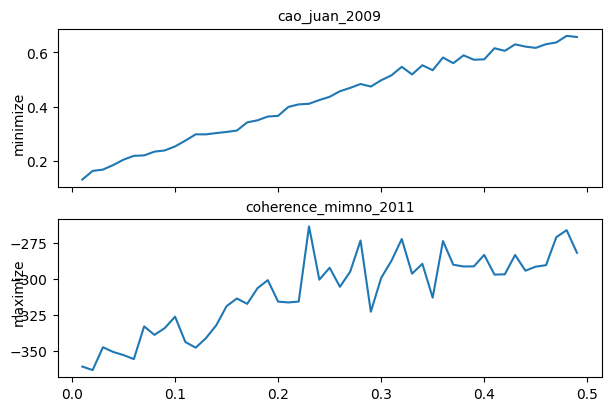

In [27]:
lda_constant_params['alpha'] = 1/(10*k)
evaluate_model(dtms, 'eta', lda_constant_params, lda_varying_params_eta)

In the above it's a little hard to determine an optimal $\beta$ value. Ideally we'd choose something that minimizes the value in the first plot and/or maximizes the value in the second, but both appear to mostly be increasing. However when we use $\alpha = 1/(20k)$ the second plot seems like it may be converging somewhere between -275 and -300. So, I am going to proceed with a $\beta$ of 0.2 and use $\alpha = 1/(20k)$.

### Build Topic Model from Top Words

In [28]:
# Pick best model to continue with
beta = 0.2
lda_constant_params['eta'] = beta
lda_constant_params['alpha'] = 1/(10*k)
# lda_constant_params['alpha'] = 1/k
print(lda_constant_params)
models = compute_models_parallel(dtms, constant_parameters=lda_constant_params)

model = models["reviews_corpus"][0][1]
print_ldamodel_topic_words(model.topic_word_, vocabulary(reviews_corpus), top_n=5)

{'n_iter': 100, 'random_state': 555, 'n_topics': 25, 'alpha': 0.004, 'eta': 0.2}
topic_1
> #1. flip (0.023699)
> #2. flop (0.023699)
> #3. good (0.023699)
> #4. color (0.021123)
> #5. pair (0.015971)
topic_2
> #1. size (0.025400)
> #2. big (0.022639)
> #3. small (0.019879)
> #4. color (0.017118)
> #5. pair (0.017118)
topic_3
> #1. comfortable (0.026688)
> #2. sandal (0.024071)
> #3. red (0.018838)
> #4. great (0.016222)
> #5. foot (0.010989)
topic_4
> #1. good (0.040168)
> #2. slipper (0.014479)
> #3. comfortable (0.014479)
> #4. bad (0.012144)
> #5. comfort (0.009809)
topic_5
> #1. pair (0.025258)
> #2. new (0.021700)
> #3. sneaker (0.019922)
> #4. good (0.019922)
> #5. price (0.018143)
topic_6
> #1. comfortable (0.043870)
> #2. great (0.025591)
> #3. size (0.022778)
> #4. comfy (0.021372)
> #5. good (0.021372)
topic_7
> #1. foot (0.067756)
> #2. wide (0.024507)
> #3. arch (0.022105)
> #4. pair (0.017299)
> #5. narrow (0.014897)
topic_8
> #1. sneaker (0.009683)
> #2. zumba (0.005282)


### Visualizing Topics

In this section we can see the 25 topics. Most give general insight, for example, great gift or comfortable sandal, bottom unglued etc. Generally it seems like they make sense but some seem to have a bit of overlap, as visualized in the LDA plot.

In [29]:
topic_labels = generate_topic_labels_from_top_words(
    model.topic_word_,
    model.doc_topic_,
    doc_lengths(dtm),
    np.array(vocab),
    n_words = 4
)

In [30]:
for topic in topic_labels:
  print(topic)

1_flip_flop_good_color
2_size_big_small_color
3_comfortable_sandal_red_great
4_good_slipper_comfortable_bad
5_pair_new_sneaker_good
6_comfortable_great_size_comfy
7_foot_wide_arch_pair
8_sneaker_zumba_variety_step
9_size_great_pair_comfortable
10_excelente_compra_como_tal
11_model_squeak_store_mesh
12_good_great_light_comfortable
13_great_gift_son_perfect
14_little_light_day_color
15_great_look_running_satisfied
16_flop_flip_pair_comfortable
17_wide_foot_nice_people
18_running_dart_price_family
19_foot_comfortable_size_sneaker
20_comfortable_sandal_nice_good
21_person_left_sole_inside
22_bottom_unglued_top_hard
23_foot_sole_mom_sandal
24_cortez_nylon_well_cheap
25_size_great_support_quality


In [31]:
doc_topic = model.doc_topic_
documentclassifications = ldamodel_top_doc_topics(doc_topic, doc_labels, top_n=3, topic_labels=topic_labels)

In [32]:
ldavis_params = parameters_for_ldavis(
    model.topic_word_,
    model.doc_topic_,
    dtm,
    vocab
)

In [33]:
try:
  import pyLDAvis
except:
  !pip install pyLDAvis==2.1.2
  import pyLDAvis

In [34]:
%matplotlib inline
vis = pyLDAvis.prepare(**ldavis_params)
pyLDAvis.enable_notebook(local=True)
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1641: Deprecat

## Looking at Reviews from Each Topic

Using the code below we can see a few reviews from each topic.

In [50]:
def print_review(df, max:int = 10):
  count = 0
  if df.shape[0] != 0:
    for row in df.itertuples(index=False):
      print(f"[{row.product}] Review:")
      print(row.full_text)
      print()
      count += 1
      if count > max:
        break

all_sentiments = documentclassifications['sentiment'].unique()

def print_sample_reviews(sentiments, data, max: int = 10):
  print("----------------------------------------")
  print(f"Classification [{topic}]")
  print("----------------------------------------")
  for sentiment in sentiments:
    print_review(data.loc[(data['sentiment'] == sentiment)], max=max)

for topic in topic_labels:
    filtered = documentclassifications[(documentclassifications['rank_1_clean'] == topic)]
    print_sample_reviews(all_sentiments, filtered, max=1)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----------------------------------------
Classification [1_flip_flop_good_color]
----------------------------------------
[Nike Men's Downshifter 5 Running Shoes] Review:
Very good shoes As always this shoes were what I was expecting, very confortable and very good quality too. Another thing that I ike is that they are very ligth for running.

[Nike The Overplay VII Men's Basketball Shoe] Review:
Love the company - I'm returning the sneakers - for color reasons I loved everything the only reason I'm returning them is that my boyfriend did not like all the white in the sneaker.I re-ordered another pair all black!

[Nike Womens Celso Girl Thong] Review:
Okay, Not Great I think the flip-flops were okay, but they're not as nice as I wanted them to be. They were a bit too narrow, and the thong part was not as soft as I expected. However, the padding was really nice and made it a lot more comfortable walking around. Honestly, I think it was a bit too expensive ($33 + $9.95 shipping) for the 



## Grouping Topics by Product

In the section below we can further analyze the topics by looking at which products appear to be related to the topics.



In [35]:
documentclassifications['rank_1_clean'] = documentclassifications['rank_1'].str.replace(r'\s*\([^()]*\)', '')

documentclassifications["full_text"] = nike_reviews['review']
documentclassifications['processed_text'] = [text['token'] for text in processed_texts]
documentclassifications["product"] = nike_reviews['product']
documentclassifications.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-35-0362562e3153>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  documentclassifications['rank_1_clean'] = documentclassifications['rank_1'].str.replace(r'\s*\([^()]*\)', '')


,rank_1,rank_2,rank_3,rank_1_clean,full_text,processed_text,product
document,,,,,,,
0,25_size_great_support_quality (0.9963),12_good_great_light_comfortable (0.0001533),2_size_big_small_color (0.0001533),25_size_great_support_quality,"Quality Shoe I wear a size 10.5&#34; shoe, ord...","[quality, size, insole, bit, different, compan...",Nike Men's Downshifter 5 Running Shoes
1,12_good_great_light_comfortable (0.7119),23_foot_sole_mom_sandal (0.2848),25_size_great_support_quality (0.0001423),12_good_great_light_comfortable,"super light, great running shoe fits perfectly...","[super, light, great, high, arch, narrow, foot...",Nike Men's Downshifter 5 Running Shoes
2,19_foot_comfortable_size_sneaker (0.9766),25_size_great_support_quality (0.0009756),12_good_great_light_comfortable (0.0009756),19_foot_comfortable_size_sneaker,Great running shoe This shoe is very light and...,"[great, light, comfortable, size]",Nike Men's Downshifter 5 Running Shoes
3,1_flip_flop_good_color (0.6564),3_comfortable_sandal_red_great (0.3285),12_good_great_light_comfortable (0.0006557),1_flip_flop_good_color,Very good shoes As always this shoes were what...,"[good, confortable, good, quality, thing, ligth]",Nike Men's Downshifter 5 Running Shoes
4,3_comfortable_sandal_red_great (0.9843),25_size_great_support_quality (0.0006557),12_good_great_light_comfortable (0.0006557),3_comfortable_sandal_red_great,"Great! These shoes were shipped quickly, came ...","[great, box, cool, swoosh, dark, happy]",Nike Men's Downshifter 5 Running Shoes
5,4_good_slipper_comfortable_bad (0.5597),5_pair_new_sneaker_good (0.4381),25_size_great_support_quality (9.732e-05),4_good_slipper_comfortable_bad,Happy for quick shipping I alredy had an idea ...,"[happy, quick, shipping, idea, type, athletic,...",Nike Men's Downshifter 5 Running Shoes
6,17_wide_foot_nice_people (0.9895),25_size_great_support_quality (0.0004396),12_good_great_light_comfortable (0.0004396),17_wide_foot_nice_people,Nice wide toe box! My son has extremely wide f...,"[nice, wide, toe, box, son, wide, foot, wide, ...",Nike Men's Downshifter 5 Running Shoes
7,5_pair_new_sneaker_good (0.9914),25_size_great_support_quality (0.0003604),12_good_great_light_comfortable (0.0003604),5_pair_new_sneaker_good,"Excellent Shoe Nice price, excellent show I lo...","[excellent, nice, price, excellent, show, ques...",Nike Men's Downshifter 5 Running Shoes
8,5_pair_new_sneaker_good (0.9905),25_size_great_support_quality (0.000396),12_good_great_light_comfortable (0.000396),5_pair_new_sneaker_good,Nice sneakers These sneakers are exactly as th...,"[nice, sneaker, sneaker, lightweight, fit, fla...",Nike Men's Downshifter 5 Running Shoes


In [36]:
def create_grouped_stacked_chart(df, paramA: str = None, paramB: str = 'rank_1_clean', normalized:bool = True, sorted:bool = True):

  display_df = df.groupby([paramB, paramA]).size().unstack(fill_value=0)

  def sort_by_numerical_prefix(s):
      # Extract numerical part of the string
      numerical_part = re.match(r'^(\d+)', s).group(1)
      return int(numerical_part)

  plt.figure(figsize=(15, 8))

  if normalized:
    display_df = display_df.div(display_df.sum(axis=1), axis=0)
  if sorted:
    display_df = display_df.sort_values(by=paramB, ascending=False,  key=lambda x: x.map(sort_by_numerical_prefix))

  display_df.plot(kind='barh', stacked=True, figsize=(12, 8))
  plt.xlabel('Distribution %')
  plt.ylabel(paramB)
  plt.title(f'Distribution of {paramA} by {paramB}')
  plt.legend(title=paramA, loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()
  return display_df


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x800 with 0 Axes>

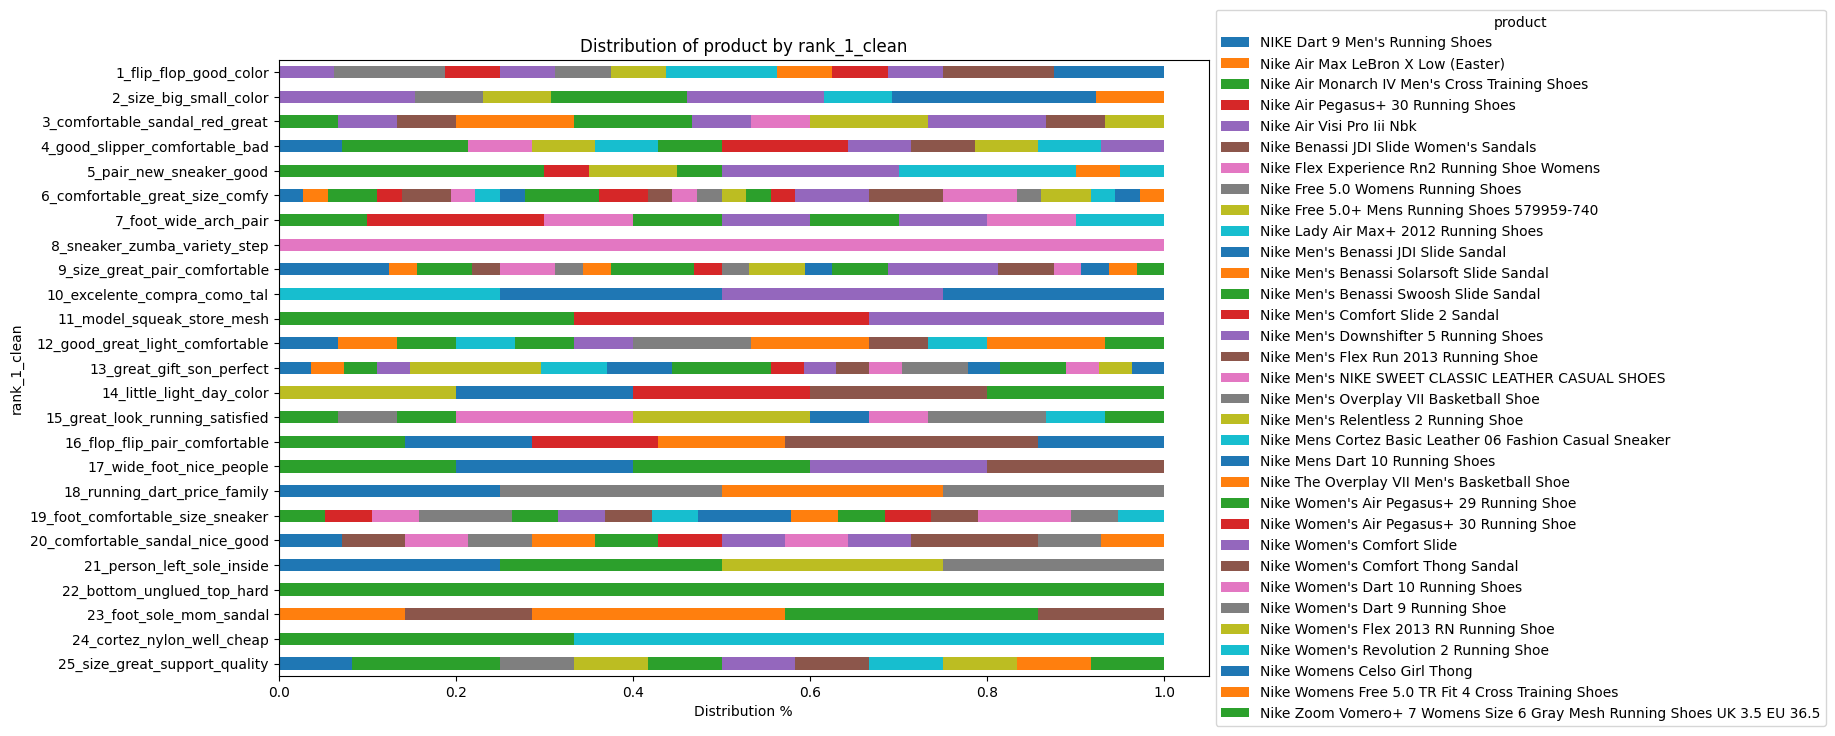

In [37]:
result_df = create_grouped_stacked_chart(documentclassifications, 'product')

Above we can see that each topic has several associated products. Obviously this is a little difficult to make sense of, so in the next block of code, we can group these products into a few categories to see how they are distributed.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x800 with 0 Axes>

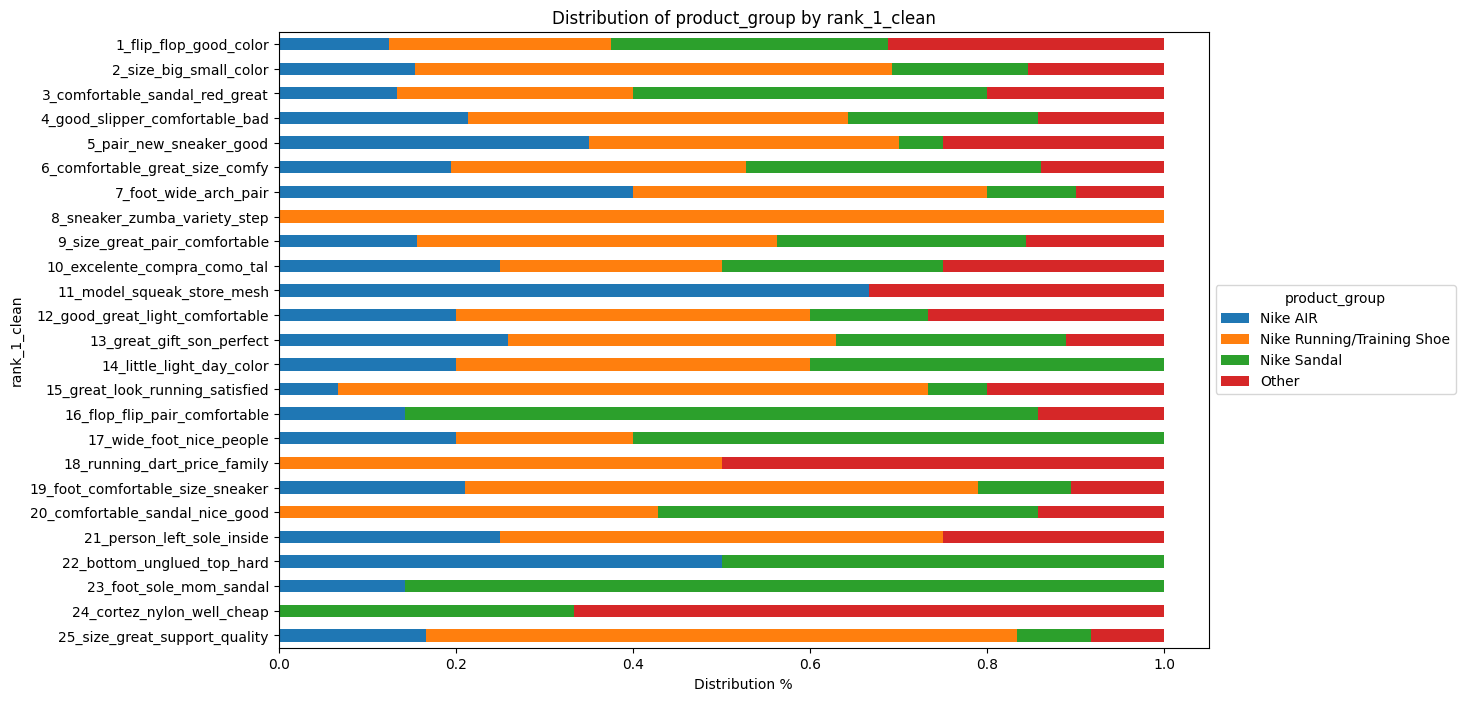

In [38]:
def get_group(product):
    product = product.upper()
    if "AIR" in product:
      return "Nike AIR"

    if any(substring in product for substring in ["SANDAL", "THONG"]):
        return "Nike Sandal"
    if any(substring in product for substring in ["RUNNING", "TRAIN"]):
      return "Nike Running/Training Shoe"
    return "Other"


documentclassifications["product_group"] = nike_reviews['product'].apply(get_group)
result_df = create_grouped_stacked_chart(documentclassifications, 'product_group')

This is much better. After simplifying we can see that it's really just different flavors of shoes but mainly sneakers and sandals. Generally speaking they're pretty evenly distributed throughout each catgory. But it's cool tosee that in some cases, where we see that the topic model represents sandals or flip flops that the majority of reviews are actually in the sandal category. This is an indication that the topic model is keying in on some of the right attributes.

# Analyzing Negative Reviews

Now that we've looked at the breakdown of products we can start to analyze specifically what kinds of insights we can gain from looking at topics with mostly negative reviews. We'll start by determining which reviews are negative. There are two main metrics, either doing a sentiment analysis for each review, or using the rating. We'll look at both and see which will be best.

In [39]:
def get_text_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    subjectivity = blob.sentiment.subjectivity

    if polarity > 0:
        if subjectivity > 0.5:
            return "Positive"
        else:
            return "Neutral"
    elif polarity < 0:
        if subjectivity > 0.5:
            return "Negative"
        else:
            return "Neutral"
    else:
        return "Neutral"

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:

documentclassifications['sentiment'] = documentclassifications['full_text'].apply(get_text_sentiment)
documentclassifications['rating'] = nike_reviews['rating']
documentclassifications.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,rank_1,rank_2,rank_3,rank_1_clean,full_text,processed_text,product,product_group,sentiment,rating
document,,,,,,,,,,
0,25_size_great_support_quality (0.9963),12_good_great_light_comfortable (0.0001533),2_size_big_small_color (0.0001533),25_size_great_support_quality,"Quality Shoe I wear a size 10.5&#34; shoe, ord...","[quality, size, insole, bit, different, compan...",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Positive,5.0
1,12_good_great_light_comfortable (0.7119),23_foot_sole_mom_sandal (0.2848),25_size_great_support_quality (0.0001423),12_good_great_light_comfortable,"super light, great running shoe fits perfectly...","[super, light, great, high, arch, narrow, foot...",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Neutral,5.0
2,19_foot_comfortable_size_sneaker (0.9766),25_size_great_support_quality (0.0009756),12_good_great_light_comfortable (0.0009756),19_foot_comfortable_size_sneaker,Great running shoe This shoe is very light and...,"[great, light, comfortable, size]",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Positive,5.0
3,1_flip_flop_good_color (0.6564),3_comfortable_sandal_red_great (0.3285),12_good_great_light_comfortable (0.0006557),1_flip_flop_good_color,Very good shoes As always this shoes were what...,"[good, confortable, good, quality, thing, ligth]",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Positive,4.0
4,3_comfortable_sandal_red_great (0.9843),25_size_great_support_quality (0.0006557),12_good_great_light_comfortable (0.0006557),3_comfortable_sandal_red_great,"Great! These shoes were shipped quickly, came ...","[great, box, cool, swoosh, dark, happy]",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Positive,5.0
5,4_good_slipper_comfortable_bad (0.5597),5_pair_new_sneaker_good (0.4381),25_size_great_support_quality (9.732e-05),4_good_slipper_comfortable_bad,Happy for quick shipping I alredy had an idea ...,"[happy, quick, shipping, idea, type, athletic,...",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Neutral,4.0
6,17_wide_foot_nice_people (0.9895),25_size_great_support_quality (0.0004396),12_good_great_light_comfortable (0.0004396),17_wide_foot_nice_people,Nice wide toe box! My son has extremely wide f...,"[nice, wide, toe, box, son, wide, foot, wide, ...",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Neutral,5.0
7,5_pair_new_sneaker_good (0.9914),25_size_great_support_quality (0.0003604),12_good_great_light_comfortable (0.0003604),5_pair_new_sneaker_good,"Excellent Shoe Nice price, excellent show I lo...","[excellent, nice, price, excellent, show, ques...",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Positive,5.0
8,5_pair_new_sneaker_good (0.9905),25_size_great_support_quality (0.000396),12_good_great_light_comfortable (0.000396),5_pair_new_sneaker_good,Nice sneakers These sneakers are exactly as th...,"[nice, sneaker, sneaker, lightweight, fit, fla...",Nike Men's Downshifter 5 Running Shoes,Nike Running/Training Shoe,Positive,5.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x800 with 0 Axes>

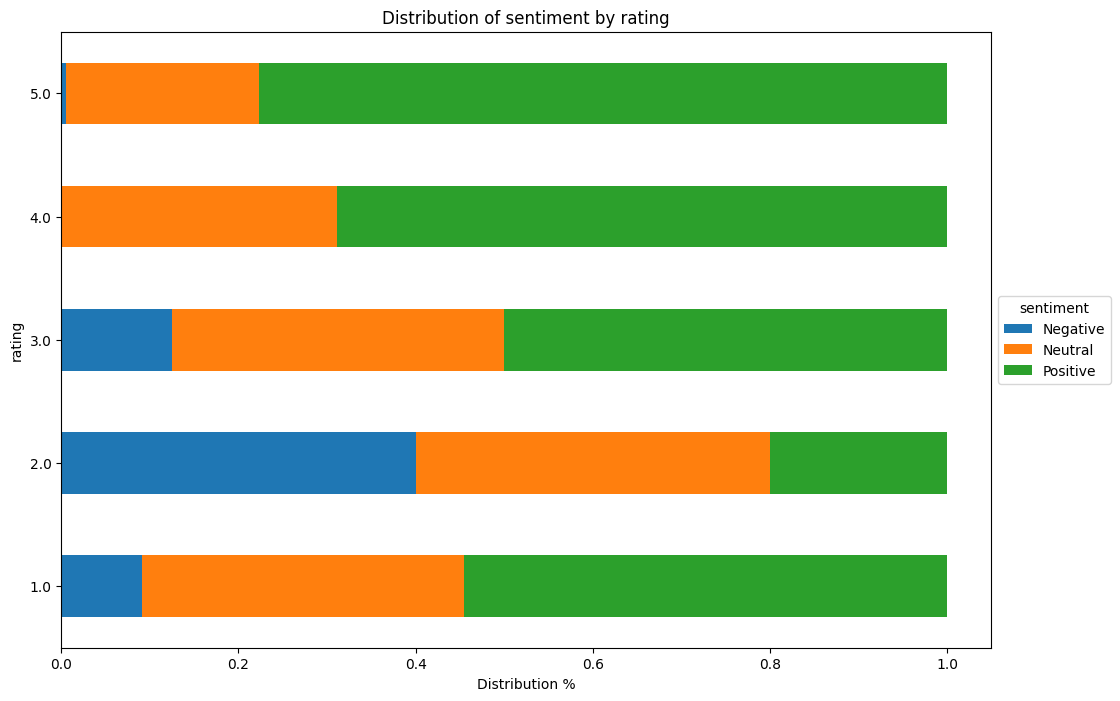

In [41]:
result_df = create_grouped_stacked_chart(documentclassifications, 'sentiment', 'rating', sorted=False)

Above, we plot the sentiment against the rating. Unfortuately it doesn't always seem like the sentiment analysis is in line with the rating on the review. We get a lot of positive sentiment even on negative reviews. After looking at a few negative reviews, I noticed that many people use words with negative connotations or may compare a product they love against a product they hate, which can confuse the sentiment analysis. Getting the sentiment right would likely be another project in itself so to move this project along, we'll proceed with using ratings to determine which reviews are positive and which are negative.

In [42]:
# Update Sentiment to be by rating instead
def get_sentiment_by_rating(rating):
  if rating <= 3:
    return "Negative"
  return "Positive"

documentclassifications['sentiment'] = documentclassifications['rating'].apply(get_sentiment_by_rating)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Figure size 1500x800 with 0 Axes>

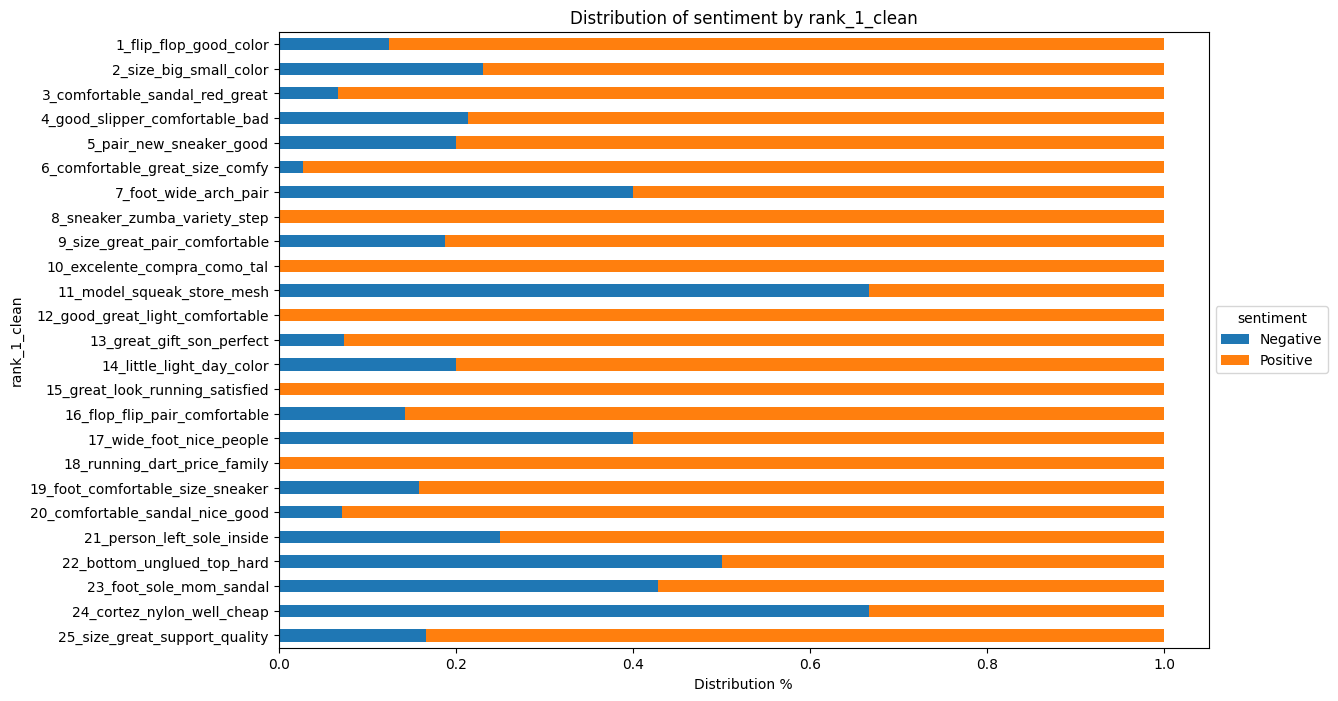

In [43]:
result_df = create_grouped_stacked_chart(documentclassifications, 'sentiment')

From this chart we can see that the majority of reviews are positive, however we want to take a look at topics with majority (50%+) negative reviews to see if we can get a sense for what people aren't liking about the products.

In [44]:
negative_topics = list(result_df[result_df['Negative'] >= 0.25].index.unique())
negative_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['24_cortez_nylon_well_cheap',
 '23_foot_sole_mom_sandal',
 '22_bottom_unglued_top_hard',
 '21_person_left_sole_inside',
 '17_wide_foot_nice_people',
 '11_model_squeak_store_mesh',
 '7_foot_wide_arch_pair']

#### Negative Topic Reviews

In [51]:
for topic in negative_topics:
    filtered = documentclassifications[(documentclassifications['rank_1_clean'] == topic)]
    print_sample_reviews(['Negative'], filtered, max=2)



----------------------------------------
Classification [24_cortez_nylon_well_cheap]
----------------------------------------
[Nike Men's Benassi Swoosh Slide Sandal] Review:
Not suitable for shower use Not bad sandals with nice, thick soles, but I purchased them for use as shower shoes (...on a US Army post).  Unfortunately, the material used in the cross-strap is absorbent.  With regular use they don't dry properly and begin to smell funky.

[Nike Mens Cortez Basic Leather 06 Fashion Casual Sneaker] Review:
could be better The Navy and white looks good is why I like them.  I plan on using them for everyday and gym work such as treadmill and squats.  They are cushy how I like for squats.  The thing I don't like it that the tongue is nylon.  I hate the Cortez nylons as they are cheesy and prefer my shoes to be leather as they last longer look better and are more comfy better made.  Nylon is just a cheap material so I avoid it as much as possible as a rule.  Nike made these Cortez cheap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Insights & Conclusions

Looking at the above, a few of the topics seem to have similar complaints, across different products, primarily with respect to having issues with the soles of the shoes/sandals, finding the shoes/sandals are too squeeky, and also that shoes tend to be narrow and not supportive of wider feet. This is good because a few of these topcis match the top words well enough that the topic indicates the probelm (ex: 7_foot_wide_arch_pair or 17_wide_foot_nice_people or 11_model_squeak_store_mesh)

 The fact that these are popping up in different topic models is both indicator that these shoes/sandals are having consistent and similar problems and that we may have too many topics. I ended up running this a few times, and reducing the number of topics/adjusting beta, but found that that made the topics too general. Instead of getting specifics I was often just seeing less descriptive words like good/bad/shoe etc.

 In all there is more tuning that could be done, and probably many more methods of preprocessing as well, but this first pass at building topic models for reviews did provide insights that some of the main issues are squeeky/uncomfortable soles and narrow fit.